In [1]:
#get started by loading the relevant libraries, not sure all of them are needed, I collected them throughout my trials
import pandas as pd
import matplotlib.pyplot as plt
import pathlib2 as pathlib
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
#from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN

In [13]:
#setting the path
cwd=pathlib.Path.cwd()
datadirpath=cwd.joinpath("data")
rawdatapath=datadirpath.joinpath("raw")

In [19]:
user_ratings_df=pd.read_csv(rawdatapath.joinpath("collaborative_books_df.csv"))
user_ratings_df=user_ratings_df.drop([user_ratings_df.columns[0]],axis=1) # removed unnamed index column
print(user_ratings_df.columns)
print(user_ratings_df.head)

Index(['title', 'book_id', 'user_id_mapping', 'book_id_mapping',
       'Predicted Rating', 'Actual Rating'],
      dtype='object')
<bound method NDFrame.head of                      title  book_id  user_id_mapping  book_id_mapping  \
0       I Am the Messenger    19057             1537              299   
1       I Am the Messenger    19057            23039              299   
2       I Am the Messenger    19057            39096              299   
3       I Am the Messenger    19057            14631              299   
4       I Am the Messenger    19057            32816              299   
...                    ...      ...              ...              ...   
196291            Coraline    17061            58417              106   
196292            Coraline    17061             9941              106   
196293            Coraline    17061            31383              106   
196294            Coraline    17061            33833              106   
196295            Coraline    17061

In [20]:
book_metadata_df=pd.read_csv(rawdatapath.joinpath("collaborative_book_metadata.csv"))
book_metadata_df=book_metadata_df.drop([book_metadata_df.columns[0]],axis=1) # removed unnamed index column
print(book_metadata_df.columns)
print(book_metadata_df.head)

Index(['book_id', 'title', 'image_url', 'url', 'num_pages', 'ratings_count',
       'description', 'genre', 'name', 'book_id_mapping'],
      dtype='object')
<bound method NDFrame.head of      book_id                                              title  \
0    5899779  Pride and Prejudice and Zombies Pride and Prej...   
1     872333                          Blue Bloods Blue Bloods 1   
2   15507958                      Me Before You Me Before You 1   
3      66559                                      Sharp Objects   
4    7235533          The Way of Kings The Stormlight Archive 1   
..       ...                                                ...   
91  10600242                                  How to Be a Woman   
92      9516   Persepolis The Story of a Childhood Persepolis 1   
93    307791                  The City of Ember Book of Ember 1   
94     37442  Wicked The Life and Times of the Wicked Witch ...   
95  29069989  Harry Potter and the Cursed Child Parts 1 2 Ha...   

       

In [21]:
import re

# Define a function to clean up genre names
def clean_genre(genre):
    if pd.isna(genre):
        return ''
    genre = genre.strip()
    genre = re.sub(r"[^\w\s,]", "", genre)  # Remove any non-alphanumeric characters except commas and spaces
    genre = genre.replace("'", "")          # Remove single quotes
    genre = genre.replace("[", "")          # Remove square brackets
    genre = genre.replace("]", "")
    genre = genre.replace(",", ", ")        # Normalize spaces around commas
    return genre

# Apply the cleaning function to the genre column
book_metadata_df['cleaned_genre'] = book_metadata_df['genre'].apply(clean_genre)




In [22]:
# One-hot encode the cleaned genre column
genre_dummies = book_metadata_df['cleaned_genre'].str.get_dummies(sep=', ')

# Combine the one-hot encoded genres with the book metadata
book_metadata_df = pd.concat([book_metadata_df, genre_dummies], axis=1)

# Drop the original genre and cleaned_genre columns if not needed
book_metadata_df = book_metadata_df.drop(columns=['genre', 'cleaned_genre'])

# Display the processed book metadata to check the new columns

print(book_metadata_df.head())

    book_id                                              title  \
0   5899779  Pride and Prejudice and Zombies Pride and Prej...   
1    872333                          Blue Bloods Blue Bloods 1   
2  15507958                      Me Before You Me Before You 1   
3     66559                                      Sharp Objects   
4   7235533          The Way of Kings The Stormlight Archive 1   

                                           image_url  \
0  https://images.gr-assets.com/books/1320449653m...   
1  https://images.gr-assets.com/books/1322281515m...   
2  https://images.gr-assets.com/books/1357108762m...   
3  https://images.gr-assets.com/books/1423241485m...   
4  https://images.gr-assets.com/books/1507307887m...   

                                                 url  num_pages  \
0  https://www.goodreads.com/book/show/5899779-pr...        320   
1  https://www.goodreads.com/book/show/872333.Blu...        302   
2  https://www.goodreads.com/book/show/15507958-m...        369  

In [23]:
# Step 4: Merge the user ratings DataFrame with the book metadata DataFrame
# Use 'book_id_mapping' as the common key, and only keep rows with metadata

# Merge the DataFrames
merged_df = pd.merge(user_ratings_df, book_metadata_df, on='book_id_mapping', how='inner')

# The 'inner' join ensures that only rows with matching 'book_id_mapping' in both DataFrames are kept.
# This automatically removes any rows from user_ratings_df that do not have corresponding metadata.

# Display the cleaned and merged DataFrame to verify
print("Merged and Filtered DataFrame Head:")
print(merged_df.head())

Merged and Filtered DataFrame Head:
                      title_x  book_id_x  user_id_mapping  book_id_mapping  \
0  We Should All Be Feminists   22738563            64847              873   
1  We Should All Be Feminists   22738563            45548              873   
2  We Should All Be Feminists   22738563             9063              873   
3  We Should All Be Feminists   22738563            27200              873   
4  We Should All Be Feminists   22738563            41888              873   

   Predicted Rating  Actual Rating  book_id_y  \
0               4.0              5    7235533   
1               4.1              4    7235533   
2               4.5              5    7235533   
3               4.2              5    7235533   
4               4.4              5    7235533   

                                     title_y  \
0  The Way of Kings The Stormlight Archive 1   
1  The Way of Kings The Stormlight Archive 1   
2  The Way of Kings The Stormlight Archive 1   
3  The W

In [24]:
#another try for step5
import pandas as pd
from sklearn.preprocessing import normalize

# Assume `merged_df` is the DataFrame obtained after merging and including metadata and genres
# Step 1: Create the user-item matrix combined with book metadata
user_item_with_metadata = merged_df.copy()

# Identify numeric columns (metadata columns plus genre dummies)
numeric_columns = ['num_pages', 'ratings_count'] + [col for col in genre_dummies.columns if pd.api.types.is_numeric_dtype(genre_dummies[col])]

# Step 2: Multiply each user's rating by the corresponding numeric metadata column
# Filter out non-numeric columns from `user_item_with_metadata`
numeric_metadata_columns = [col for col in numeric_columns if col in user_item_with_metadata.columns]

# Ensure 'Actual Rating' is numeric
user_item_with_metadata['Actual Rating'] = pd.to_numeric(user_item_with_metadata['Actual Rating'], errors='coerce')

# Apply multiplication only on numeric columns
for col in numeric_metadata_columns:
    if col in user_item_with_metadata.columns:
        user_item_with_metadata[col] = user_item_with_metadata['Actual Rating'] * user_item_with_metadata[col]

# Drop non-numeric columns before aggregation
user_item_with_metadata_numeric = user_item_with_metadata[numeric_metadata_columns + ['user_id_mapping']]

# Step 3: Aggregate the vectors for each user
user_vectors = user_item_with_metadata_numeric.groupby('user_id_mapping').mean()

# Step 4: Normalize the vectors (optional)
#user_vectors_normalized = pd.DataFrame(
#    normalize(user_vectors, norm='l2'),
#    index=user_vectors.index,
#    columns=user_vectors.columns
#)

# Step 5: Review the final user vectors
print("Aggregated and Normalized User Vectors Head:")
print(user_vectors.head())

Aggregated and Normalized User Vectors Head:
                 num_pages  ratings_count   biography   children   comics  \
user_id_mapping                                                             
2                   1240.0       826584.0         0.0        0.0      0.0   
4                    720.0       414009.0         0.0        3.0      0.0   
7                   1164.0      1494384.0         4.0        0.0      4.0   
21                   448.0       402392.0         0.0        0.0      0.0   
23                   720.0       292370.0         0.0        0.0      0.0   

                  crime   fantasy   fiction   graphic   historical fiction  \
user_id_mapping                                                              
2                   0.0       4.0       4.0       0.0                  0.0   
4                   0.0       0.0       3.0       0.0                  0.0   
7                   0.0       0.0       4.0       4.0                  4.0   
21                  2.0  

In [25]:

# Standardize the data (important for DBSCAN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(user_vectors)

In [27]:
# Strip leading and trailing spaces from the column names
user_vectors.columns = user_vectors.columns.str.strip()

# Verify that the column names have been cleaned
print(user_vectors.columns)

Index(['num_pages', 'ratings_count', 'biography', 'children', 'comics',
       'crime', 'fantasy', 'fiction', 'graphic', 'historical fiction',
       'history', 'mystery', 'nonfiction', 'paranormal', 'poetry', 'romance',
       'thriller', 'youngadult', 'children', 'comics', 'fantasy', 'fiction',
       'mystery', 'nonfiction', 'poetry', 'romance', 'youngadult'],
      dtype='object')


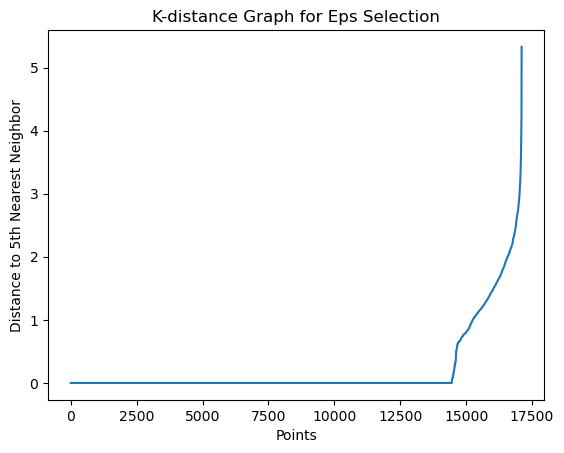

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

# Assuming 'user_vectors' is your DataFrame with features
# Select only the relevant columns for clustering (e.g., drop 'cluster' or non-feature columns)
features = user_vectors[['num_pages', 'ratings_count', 'biography', 'children', 'comics', 
                         'crime', 'fantasy', 'fiction', 'graphic', 'historical fiction', 
                         'history', 'mystery', 'nonfiction', 'paranormal', 'poetry', 
                         'romance', 'thriller', 'youngadult']]  # Example of selected columns

# Step 1: Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Step 2: Define NearestNeighbors and compute distances
neighbors = NearestNeighbors(n_neighbors=5)  # Set n_neighbors to min_samples or another reasonable value
neighbors_fit = neighbors.fit(X_scaled)

# Step 3: Find the k-neighbors for each point
distances, indices = neighbors_fit.kneighbors(X_scaled)

# Step 4: Sort the distances for k-nearest neighbors and plot
distances = np.sort(distances[:, 4], axis=0)  # 4 corresponds to the 5th nearest neighbor (index 4 = n_neighbors - 1)
plt.plot(distances)
plt.title('K-distance Graph for Eps Selection')
plt.xlabel('Points')
plt.ylabel('Distance to 5th Nearest Neighbor')
plt.show()

In [29]:
# Initialize DBSCAN with chosen parameters
dbscan = DBSCAN(eps=2.5, min_samples=3)

# Fit the model to the scaled data

clusters = dbscan.fit_predict(X_scaled)

# The labels assigned to each data point (cluster ID, -1 for noise)
labels = dbscan.labels_

# Add cluster labels to the original DataFrame
user_vectors['cluster'] = clusters

In [30]:
# Number of clusters (excluding noise)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

# Number of noise points
n_noise = list(labels).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

Estimated number of clusters: 14
Estimated number of noise points: 69


In [31]:
# Get cluster profiles
cluster_profiles = user_vectors.groupby('cluster').mean()
print(cluster_profiles)

            num_pages  ratings_count  biography  children    comics     crime  \
cluster                                                                         
-1        2110.164251   1.377501e+06   1.814010  0.946860  0.405797  1.289855   
 0        1395.662403   9.827732e+05   0.909675  0.640455  0.295313  1.122056   
 1       10340.423077   7.295832e+05   0.019231  2.604167  0.000000  2.668269   
 2         988.611111   2.633004e+06   2.027778  1.805556  0.000000  0.000000   
 3         940.000000   1.971555e+06   2.500000  0.000000  0.000000  0.000000   
 4       16400.000000   7.722280e+05   0.000000  4.000000  0.000000  4.000000   
 5         764.196970   1.111481e+06   1.924242  0.363636  1.924242  0.363636   
 6         919.095238   2.472354e+06   0.000000  2.333333  0.000000  0.190476   
 7        1195.357143   1.503623e+06   2.642857  0.000000  0.000000  4.285714   
 8       20500.000000   9.652850e+05   0.000000  5.000000  0.000000  5.000000   
 9         880.000000   5.14

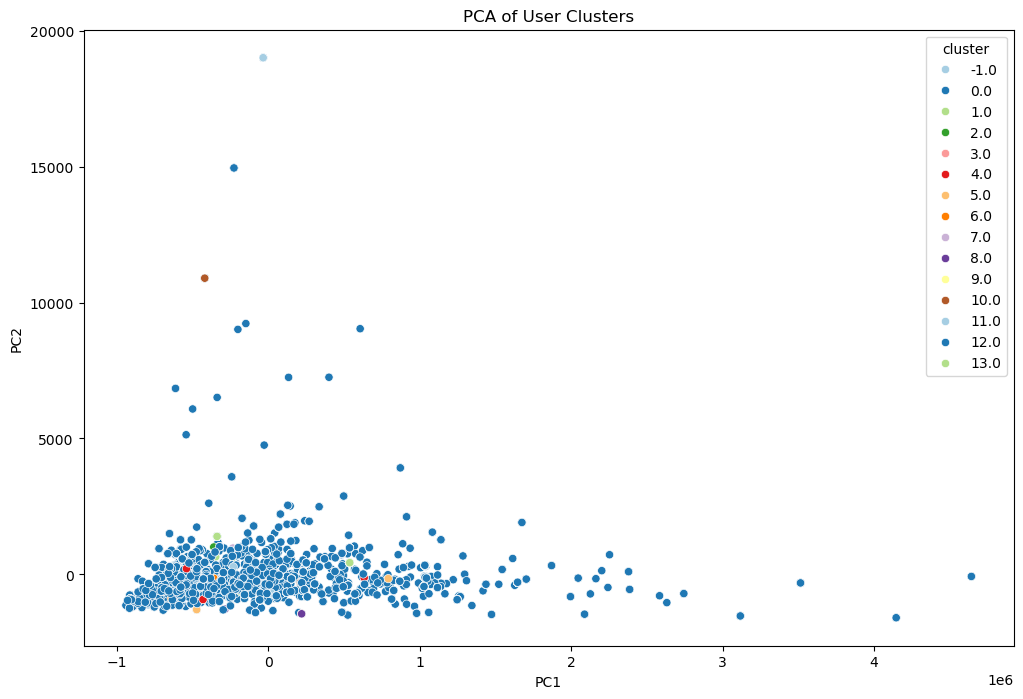

In [32]:
#initially it was viridis color palette, but that was very monotonic, changed it to Paired, still not very helpful

from sklearn.decomposition import PCA
import seaborn as sns

# Reduce to 2D for visualization
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(user_vectors.drop('cluster', axis=1))

# Create a DataFrame for plotting
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])
df_pca['cluster'] = user_vectors['cluster']

# Plot the clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='Paired', legend='full')
plt.title('PCA of User Clusters')
plt.show()

In [33]:
# trying out 3d visualization, see if that helps, tried out with 25 clusters, very unsatisfying, trying with 75 clusters, not really helping either
# prepare data for it

from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA to reduce to 3D
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(user_vectors.drop('cluster', axis=1))

# Create a DataFrame for plotting
df_pca = pd.DataFrame(reduced_data, columns=['PC1', 'PC2', 'PC3'])
df_pca['cluster'] = user_vectors['cluster']

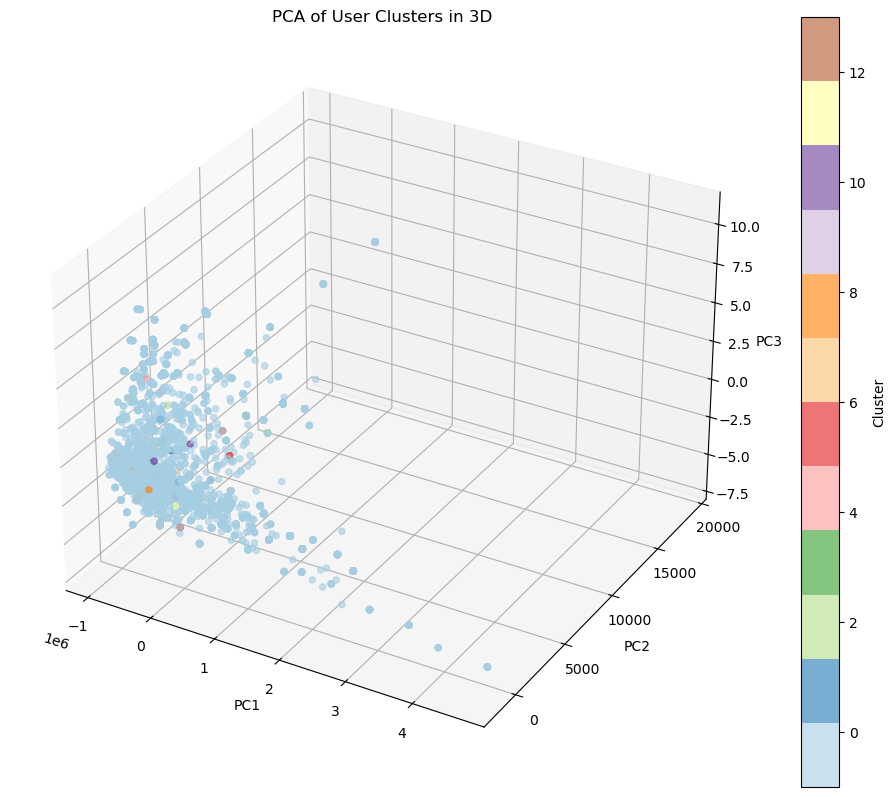

In [35]:
#create 3D scatter plot, starting with Viridis again

from mpl_toolkits.mplot3d import Axes3D

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot
scatter = ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'], 
                     c=df_pca['cluster'], cmap='Paired', alpha=0.6)

# Add color bar
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster')

# Labels and title
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('PCA of User Clusters in 3D')

plt.show()